## Описание проекта

Стартапу, который продаёт продукты питания, нужно разобраться как ведут себя пользователи мобильного приложения.

Для того, чтобы в этом разобраться в рамках проекта я изучу воронку продаж. Узнаю, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?

После этого исследую результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Для того чтобы принять решение проведу A/A/B-теста.


Проект будет реализовываться в несколько шагов
1. Подготовка данных
2. Предобработка данных
3. Изучение воронки событий
4. Изучение результатов эксперимента


### Описание данных

Логи пользователей мабильного приложения (файл logs_exp.csv)

EventName — название события;

DeviceIDHash — уникальный идентификатор пользователя;

EventTimestamp — время события;

ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

### Шаг 1. Подготовка данных

In [1]:
import pandas as pd
import warnings as wr
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

In [2]:
wr.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# снимаем ограничение на ширину столбцов
#pd.set_option('display.max_colwidth', None)
#pd.options.display.float_format = '{:,.2f}'.format

In [3]:
try: 
    logs = pd.read_csv('C:/Users/crugl/Downloads/Сборный проект2/logs_exp.csv', sep='\t')
except:
    logs = pd.read_csv('/datasets/logs_exp.csv', sep='\t')

In [4]:
def processing (data):
    """
    Функция будет выводить информацию о явных дубликатах
    и пропусков в данных 
    """
    duplicated_sum = data.duplicated().sum()
    gap_sum = data.isna().sum()
    print(data.info())
    print()
    print('Количество явных дубликатов:', duplicated_sum)
    print('Количество пропусков:')
    print(gap_sum)

### Предобработка данных

In [5]:
processing(logs)
logs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB
None

Количество явных дубликатов: 413
Количество пропусков:
EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [6]:
logs = logs.rename(columns={'EventName': 'event_name', 'DeviceIDHash': 'user_id', 
                            'EventTimestamp': 'event_date', 'ExpId': 'group_id'})

In [7]:
logs['event_date'] = pd.to_datetime(logs['event_date'], unit='s')

In [8]:
logs['date'] = logs['event_date'].dt.to_period('D')

In [9]:
logs = logs.drop_duplicates().reset_index(drop=True)

In [10]:
processing(logs)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  243713 non-null  object        
 1   user_id     243713 non-null  int64         
 2   event_date  243713 non-null  datetime64[ns]
 3   group_id    243713 non-null  int64         
 4   date        243713 non-null  period[D]     
dtypes: datetime64[ns](1), int64(2), object(1), period[D](1)
memory usage: 9.3+ MB
None

Количество явных дубликатов: 0
Количество пропусков:
event_name    0
user_id       0
event_date    0
group_id      0
date          0
dtype: int64


In [11]:
logs.head()

,event_name,user_id,event_date,group_id,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


In [12]:
logs.groupby('user_id')['group_id'].nunique().reset_index().query('group_id > 1')

,user_id,group_id


Пользователей, которые участвуют сразу в нескольких групп нет.

In [13]:
unique_users = logs['user_id'].nunique()
print('Всего уникальных пользователей:', unique_users)

Всего уникальных пользователей: 7551


Всего уникальных пользователей 7551

In [14]:
total_event = len(logs)
print('Количество событий:', total_event)

Количество событий: 243713


In [15]:
len(logs)/logs['user_id'].nunique()

32.27559263673685

В среднем на одного пользователя приходится 32 события

In [16]:
logs['date'].max()

Period('2019-08-07', 'D')

Максимальная дата имеющихся данных

In [17]:
logs['date'].min()

Period('2019-07-25', 'D')

Минимальная дата имеющихся данных

In [18]:
sns.set(rc = {'axes.facecolor':'#F5F5F5', 'figure.figsize':(20,10)}, font_scale=1.5)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 [Text(0, 0, '2019-07-25'),
  Text(1, 0, '2019-07-26'),
  Text(2, 0, '2019-07-27'),
  Text(3, 0, '2019-07-28'),
  Text(4, 0, '2019-07-29'),
  Text(5, 0, '2019-07-30'),
  Text(6, 0, '2019-07-31'),
  Text(7, 0, '2019-08-01'),
  Text(8, 0, '2019-08-02'),
  Text(9, 0, '2019-08-03'),
  Text(10, 0, '2019-08-04'),
  Text(11, 0, '2019-08-05'),
  Text(12, 0, '2019-08-06'),
  Text(13, 0, '2019-08-07')])

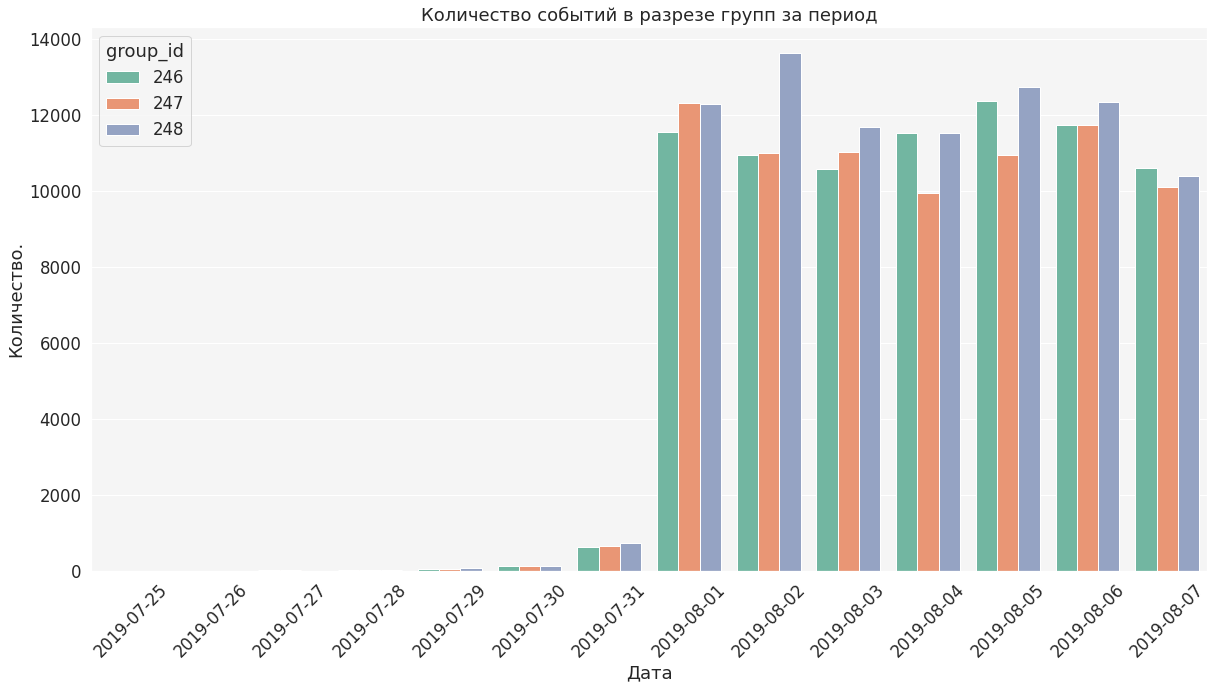

In [19]:
(
    sns.countplot(
        data=logs, 
        x='date', 
        hue='group_id',
        palette='Set2')
    
    .set(xlabel='Дата', 
     ylabel='Количество.', 
     title='Количество событий в разрезе групп за период')
)
plt.xticks(rotation=45)

In [20]:
logs = logs.query('event_date >= "2019-08-01"')

Судя по графику выше, данные за июль неполные. Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Поэтому, чтобы избежать этой проблемы, возьмем данные с 01.08.2019 по 07.08.2019

In [21]:
corr_users = logs['user_id'].nunique()
print('Количество уникальных пользователей после скоращения рассматриваемого периода:', corr_users)

Количество уникальных пользователей после скоращения рассматриваемого периода: 7534


In [22]:
corr_events = len(logs)
print('Количество событий после скоращения рассматриваемого периода:', corr_events)

Количество событий после скоращения рассматриваемого периода: 240887


In [23]:
diff_users = unique_users - corr_users
print('Потеря уникальных пользователей после сокращения рассматриваемого периода:', diff_users)
users_ratio = 1-corr_users/unique_users
print('Потеря уникальных пользователей после сокращения рассматриваемого периода в процентах:', '({:.2%})'.format(users_ratio))

Потеря уникальных пользователей после сокращения рассматриваемого периода: 17
Потеря уникальных пользователей после сокращения рассматриваемого периода в процентах: (0.23%)


In [24]:
diff_events = total_event - corr_events
print('Потеря событий после сокращения рассматриваемого периода:', diff_users)
users_ratio = 1-corr_events/total_event
print('Потеря событий после сокращения рассматриваемого периода в процентах:', '({:.2%})'.format(users_ratio))

Потеря событий после сокращения рассматриваемого периода: 17
Потеря событий после сокращения рассматриваемого периода в процентах: (1.16%)


In [25]:
logs.groupby('group_id').agg({'user_id': 'nunique'})

,user_id
group_id,
246,2484
247,2513
248,2537


In [26]:
logs.groupby('group_id').agg({'user_id': 'count'})

,user_id
group_id,
246,79302
247,77022
248,84563


__Вывод__

* После удаления дубликатов в логе осталось 243713 событий

* Уникальных пользователей - 7551

* В среднем на пользователя приходится 32 события

* В распоряжении данные за период с 25.07.2019 по 07.08.2019.Судя по графику выше данные за июль неполные. Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Поэтому, чтобы избежать этой проблемы, возьмем данные с 01.08.2019 по 07.08.2019

* После корректировки основного датафрейма остался 7534 пользователя и 240887 события

### Шаг 4. Изучите воронку событий

In [27]:
events = (
    logs.groupby('event_name')
    .agg({'user_id': 'count'})
    .reset_index()
    .rename(columns={'user_id' : 'total_events'})
    .sort_values(by='total_events', ascending=False)
)

In [28]:
events

,event_name,total_events
1,MainScreenAppear,117328
2,OffersScreenAppear,46333
0,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


In [29]:
users_funnel = (
    logs
    .groupby('event_name')
    .agg({'user_id': 'nunique'})
    .reset_index()
    .rename(columns={'user_id' : 'total_users'})
    .sort_values(by='total_users', ascending=False)
)
users_funnel['percent'] = users_funnel['total_users'] / logs['user_id'].nunique() * 100  # NEW!!!

In [30]:
users_funnel

,event_name,total_users,percent
1,MainScreenAppear,7419,98.473586
2,OffersScreenAppear,4593,60.963632
0,CartScreenAppear,3734,49.561986
3,PaymentScreenSuccessful,3539,46.973719
4,Tutorial,840,11.149456


Главную страницу увидели 7419 пользователей или 98% пользователей

Каталог предложений просмотрели 4593 пользователей или 61% пользователей

Карточку товара 3734 пользователя или 49% пользователей

Завершили оплату 3539 пользователей или 47% пользователей

Урок просмотрели 840 пользователей или 11% пользователей

Все события выстраиваются в цепочку, кроме просмотра Tutorial
Мы видим, что все события выстраиваются в цепочку действий, кроме просмотра урока (Tutorial). Этот шаг из цепочки можно убрать.

Конечная последовательность выглядит так:

* Главный экран
* Каталог предложений
* Карточка товара
* Экран с подтверждением успешной оплаты

In [31]:
event_sequence = logs.pivot_table(
                           index='user_id', 
                           columns='event_name', 
                           values='event_date',
                           aggfunc='min')

In [32]:
print('Посетителей всего:', 
      '({:.1%})'.format(event_sequence['MainScreenAppear'].count() / event_sequence['MainScreenAppear'].count() ))
print('Просмотрели Каталог в % от предыдущего шага:', 
      '({:.1%})'.format(event_sequence['OffersScreenAppear'].count() / event_sequence['MainScreenAppear'].count() ))
print('Просмотрели Карточку товара в % от предыдущего шага:', 
      '({:.1%})'.format(event_sequence['CartScreenAppear'].count() / event_sequence['OffersScreenAppear'].count()))
print('Оплатили в % от предыдущего шага:',
      '({:.1%})'.format(event_sequence['PaymentScreenSuccessful'].count() / event_sequence['CartScreenAppear'].count()))

Посетителей всего: (100.0%)
Просмотрели Каталог в % от предыдущего шага: (61.9%)
Просмотрели Карточку товара в % от предыдущего шага: (81.3%)
Оплатили в % от предыдущего шага: (94.8%)


Больше всего пользователей теряется после первого шага. До оплаты доходит только 48% пользователей


__Вывод__

Из последовательности был удален шаг "Tutorial"

Конечная последовательность выглядит так:

Главный экран
Каталог предложений
Карточка товара
Экран с подтверждением успешной оплаты

По результатам скорректированной воронки, можно сделать вывод о том что наибольшее количество пользователей теряется после первого шага, т.е. просматривают каталог лишь 61% пользователей и только 48% пользователей оплачивают товары из корзины. 

### Шаг 5. Изучите результаты эксперимента

In [33]:
logs.groupby('group_id').agg(count=('user_id', 'nunique'))

,count
group_id,
246,2484
247,2513
248,2537


In [34]:
funnel_group = (logs
                .groupby(['event_name', 'group_id'])
                .agg({'user_id': 'nunique'})
                .reset_index()
                .rename(columns={'user_id' : 'total_users'})
                .sort_values(by=['group_id','total_users'], ascending=False))

funnel_group = funnel_group.query('event_name != "Tutorial"')

In [35]:
funnel_group

,event_name,group_id,total_users
5,MainScreenAppear,248,2493
8,OffersScreenAppear,248,1531
2,CartScreenAppear,248,1230
11,PaymentScreenSuccessful,248,1181
4,MainScreenAppear,247,2476
7,OffersScreenAppear,247,1520
1,CartScreenAppear,247,1238
10,PaymentScreenSuccessful,247,1158
3,MainScreenAppear,246,2450
6,OffersScreenAppear,246,1542


Для того чтобы проверить различаются ли два средних значения ген. совокупности, когда дисперсии известны и размер выборки велик с помощью z-теста

Уровень значимости примем равный 0.05

Для того, чтобы снизить вероятность ложнопозитивного результаты при множественном тестировании, будет использована поправка Бонферрони.

Сформируем функцию

In [36]:
def z_test(df1, df2, event, alpha, n):
    '''    
Функция принимает на вход два датафрейма с логами и по заданному событию попарно проверяет 
есть ли статистически значимая разница между долями пользователей, совершивших его в группе 1 и группе 2.

Входные параметры:
    - df1, df2 - датафреймы с логами
    - event - событие
    - alpha - критический уровень статистической значимости
    - n - поправка Боннферони для критического уровня статистической значимости
    '''    
    
    # критический уровень статистической значимости c поправкой Бонферрони
    bonferroni_alpha = alpha / n
 
    # число пользователей в группе 1 и группе 2:
    n_users = np.array([df1['user_id'].nunique(), 
                        df2['user_id'].nunique()])

    # число пользователей, совершивших событие в группе 1 и группе 2
    success = np.array([df1[df1['event_name'] == event]['user_id'].nunique(), 
                        df2[df2['event_name'] == event]['user_id'].nunique()])

    # пропорции успехов в группах:
    p1 = success[0]/n_users[0]
    p2 = success[1]/n_users[1]
    
    # пропорция успехов в комбинированном датасете:
    p_combined = (success[0] + success[1]) / (n_users[0] + n_users[1])

    # разница пропорций в датасетах
    difference = p1 - p2 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference /  np.sqrt(p_combined * (1 - p_combined) * (1/n_users[0] + 1/n_users[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  

    p_value = (1 - distr.cdf(abs(z_value))) * 2   #тест двусторонний, удваиваем результат
    
    print('Событие:', event)
    print('p-значение: ', p_value)

    if p_value < bonferroni_alpha:
        print('Отвергаем нулевую гипотезу: между долями есть разница')
    else:
        print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

Для всех тестов можно сформулировать следующие гипотезы

H0: Между долями тестируемых групп разницы нет

H1: Между долями тестируемых групп есть статистически значимая разница

Проверим наличие статистической значимости в группах 246 и 247

In [37]:
for event in funnel_group['event_name'].unique():
    z_test(logs[logs['group_id'] == 246], logs[logs['group_id'] == 247], event,.05, 16)
    print()

Событие: MainScreenAppear
p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: CartScreenAppear
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



А/А тест проводят перед А/В тестом для того чтобы убедиться что инструмент "деления" трафика работает безошибочно, что данные отправляются в системы аналитики корректно и что на результаты не влияют аномалии и выбросы в генеральной совокупности.

Если в ходе А/А теста не удаётся отвергнуть нулевую гипотезу о равенстве между долями, то можно запускать А/В тест

Между группами 246 и 247 ни по одному событию нет статистически достоверного отличия при заданном уровне значимости. Значит, можно начинать А/В тест



Проверим наличие статистической значимости в группах 246 и 248

In [38]:
for event in funnel_group['event_name'].unique():
    z_test(logs[logs['group_id'] == 246], logs[logs['group_id'] == 248], event,.05, 16)
    print()

Событие: MainScreenAppear
p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: CartScreenAppear
p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Между группами 246 и 248 ни по одному событию нет статистически достоверного отличия при заданном уровне значимости.

Проверим наличие статистической значимости в группах 247 и 248

In [39]:
for event in funnel_group['event_name'].unique():
    z_test(logs[logs['group_id'] == 247], logs[logs['group_id'] == 248], event,.05, 16)
    print()

Событие: MainScreenAppear
p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: CartScreenAppear
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Между группами 247 и 248 ни по одному событию нет статистически достоверного отличия при заданном уровне значимости.

Теперь проверим наличие статистической значимости в объединенной контрольной группе и 248

In [40]:
for event in funnel_group['event_name'].unique():
    z_test(logs[logs['group_id'] != 248], logs[logs['group_id'] == 248], event,.05, 16)
    print()

Событие: MainScreenAppear
p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: CartScreenAppear
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Между группами объединенной контрольной и 248 группой ни по одному событию нет статистически достоверного отличия при заданном уровне значимости, а значит, что изменение шрифтов не дало никакого эффекта.

### Вывод

В рамках проекта были исследованы поведение покупателей и результаты А/А и А/В теста.

__По итогу исследования мы узнали что:__

Каталог предложений просмотрели 4593 пользователей или 61% пользователей

Карточку товара 3734 пользователя или 49% пользователей

Завершили оплату 3539 пользователей или 47% пользователей

Урок просмотрели 840 пользователей или 11% пользователей


После первого шага теряется около 38%, после просмотра каталога в карточку продукта приходит на 9% меньше пользователей и на оплате теряется еще 2% пользователей.

__Результаты А/А/В теста.__

В рамках теста проверяли как повлияело изменение шрифта на поведение пользователей.

Сравнивались доли пользователей по каждому событию между:

* Контрольными группами 246 и 247
* Каждой из контрольной группы по отдельности и экспериментальной (246-248 и 247-248)
* Объединенной контрольной группой и экспериментальной (246+247 и 248)

Множесто А/В-тестов, проведённых по каждому из событий, не обнаружили статистически значимой разницы между группами. Т.е. изменение шрифтов во всём приложении на поведение пользователей не повлияло.